In [1]:
import GPy
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

{'covariance': [[<matplotlib.lines.Line2D at 0x7fb55a4bf7f0>]]}

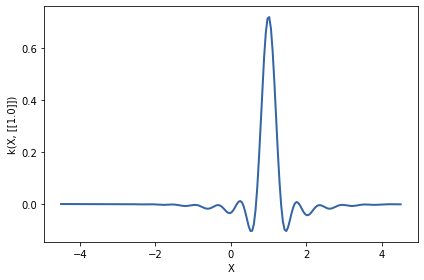

In [2]:
# カーネルの可視化(1次元)
kern = GPy.kern.PeriodicExponential(lengthscale=.1, variance=3) * GPy.kern.Matern32(1)
kern.plot()

The following kwargs were not used by contour: 'label', 'linewidth'
Please checking contour.py


{'covariance': [<matplotlib.contour.QuadContourSet at 0x7fb559d62310>]}

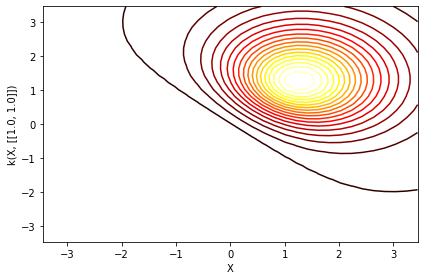

In [3]:
# カーネルの可視化(1次元)
kern = GPy.kern.Linear(input_dim=2) * GPy.kern.Matern52(input_dim=2)
kern.plot()

Text(0.5, 1.0, 'Train Date')

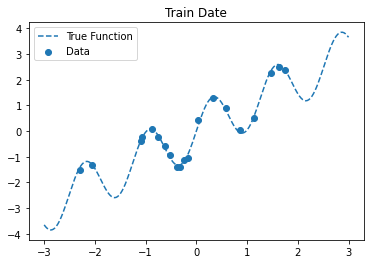

In [4]:
# データ作成
def true_function(x):
    return x+np.sin(5*x)

np.random.seed(1)
x_train = np.random.normal(0,1.,20)
y_train = true_function(x_train) + np.random.normal(loc=0, scale=.1, size=x_train.shape)
x_lin = np.linspace(-3,3,200)
plt.scatter(x_train,y_train,label='Data')
plt.plot(x_lin,true_function(x_lin),"--",color="C0", label="True Function")
plt.legend() # legend:凡例
plt.title("Train Date")

In [5]:
import GPy.kern as gp_kern
#kern = gp_kern.RBF(input_dim=1) + gp_kern.Bias(input_dim=1)
kern = gp_kern.PeriodicExponential(input_dim=1)
gpy_model = GPy.models.GPRegression(X=x_train.reshape(-1,1),
                                   Y=y_train.reshape(-1,1), kernel=kern, normalizer=None) 
#1次元で渡す，reshapeの-1は良しなに調整してくれる
#normalizer:Yの正規化を決定する変数，Noneでガウス正規化
#noise_var:データのノイズの分散を指定,defaultで1

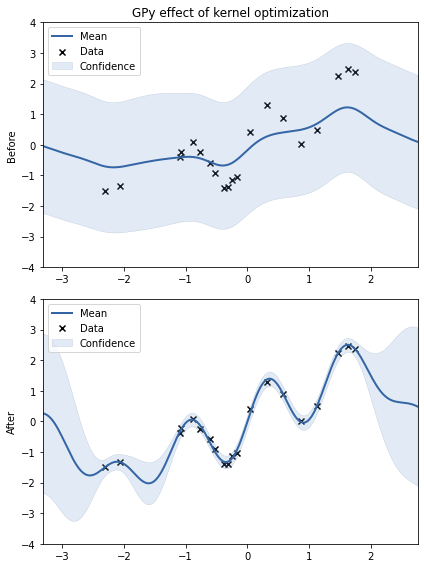

In [6]:
fig = plt.figure(figsize=(6,8)) #inch
ax1 = fig.add_subplot(211) # 2行２列の1番目に表示
gpy_model.plot(ax=ax1) # 最適化前の予測

gpy_model.optimize()

ax2 = fig.add_subplot(212, sharex=ax1)
gpy_model.plot(ax=ax2) # カーネル最適化後の予測

ax1.set_ylim(ax2.set_ylim(-4,4))
ax1.set_title("GPy effect of kernel optimization")
ax1.set_ylabel("Before")
ax2.set_ylabel("After")
fig.tight_layout() #ラベルが重ならないように余白を調整

In [7]:
# 最適化されたモデルの確認
print(gpy_model)


Name : GP regression
Objective : 6.799282795295223
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.                    |                 value  |  constraints  |  priors
  periodic_exponential.variance     |    2.8505767120748398  |      +ve      |        
  periodic_exponential.lengthscale  |    0.4162483077612404  |      +ve      |        
  periodic_exponential.period       |    11.478988404775505  |      +ve      |        
  Gaussian_noise.variance           |  0.009239716360850013  |      +ve      |        


Text(0.5, 1.0, 'Prediction by GPR')

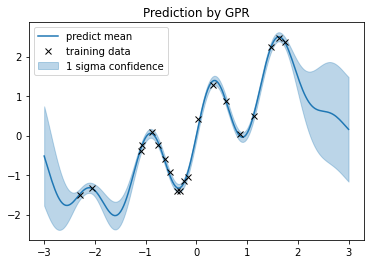

In [8]:
# テストデータを用いたGPRによる予測

def plot_result(x_test, mean, std):
    plt.plot(x_test[:, 0], mean, color="C0", label="predict mean")
    plt.fill_between(x_test[:, 0], mean + std, mean - std, color="C0", alpha=.3,label= "1 sigma confidence")
    plt.plot(x_train, y_train, "x",c="black",label= "training data")

x_test = np.linspace(-3., 3., 200).reshape(-1, 1)
pred_mean, pred_var = gpy_model.predict(x_test.reshape(-1, 1), )
pred_std = pred_var ** .5
plot_result(x_test, mean=pred_mean[:,0], std=pred_std[:,0])
plt.legend()
plt.title("Prediction by GPR")

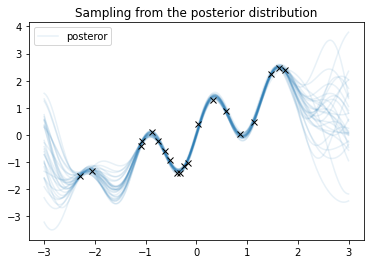

In [9]:
# 事後分布からのサンプリング
posterior = gpy_model.posterior_samples_f(x_test.reshape(-1,1), size=30)

for i, pos in enumerate(posterior.T): #横ベクトルにして取り出す
    label = None
    if i == 0:
        label = "posteror"
    plt.plot(x_test[:, 0], pos[0,:], color="C0", alpha=.1, label=label)
    #print(pos[0,:])
plt.plot(x_train, y_train, "x",c="black")
plt.title("Sampling from the posterior distribution")
plt.legend()
plt.savefig("posterior.png", dpi=150)